In [1]:
import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from ops import linear

In [2]:
sess = tf.InteractiveSession()

In [3]:
batch_size = 100

# The number of dimensions of noise to give the generator.
input_size = 1
output_size = 2
# The data we're trying to fit
data = [[math.cos(x/500)+(np.random.uniform()-0.5)/5, math.sin(x/500)+(np.random.uniform()-0.5)/5] for x in range(-2000, 2000)]
# data = [[x, math.sin(x*5)+(np.random.uniform()-0.5)/5] for x in np.arange(-1,1,.0005)]

# Creating the Network

GANs consist of two parts: 1. a generator, G, mapping from an input space (with elements here named z) to an output space, and 2. a discriminator, D, which attempts to distinguish between points in a true underlying distribution and those generated by G.

Below is a simple GAN of (arbitrarily many) fully connected layers for each of G and D. The input and outputs can be any dimensionality, and the true data distribution can be defined in any manner (note however that the plotting will only work nicely for 2D output spaces).

In [4]:
z = tf.placeholder(tf.float32, [None, input_size], name='z')
def create_g_output(g_input):
    generator_layers = [16, 16] # Number of nodes in each layer, try tweaking!
    # A reasonable value for weight standard deviations is necessary to prevent 
    # explosion/collapse. Consider using Xavier initialization in the future.
    stddev = 0.5
    layer_input = g_input
    for i, layer_size in enumerate(generator_layers):
        output = tf.nn.relu(linear(layer_input, layer_size, scope="g_{0}".format(i), stddev=stddev))
        layer_input = output
    return linear(layer_input, output_size, scope="g_final", stddev=stddev)
g_output = create_g_output(z)

In [5]:
""" 
Create two discriminators reusing the variables for each but 
different inputs and outputs. The reason for this is as follows:
We want to allow gradients to flow from the discriminator output
back to the generator in order for the generator to get a signal 
of how to do better. Hence we'd like the g_output to be an input
to D. Additionally we need to be able to feed D examples generated 
from the true distribution, i.e. its input should be a placeholder, 
which takes in values (numbers) rather than nodes (variables). We 
can't use placeholders for parameters that need to be learned, 
hence there are two separate inputs to D with two outputs, but only 
one D.
"""
discriminator_layers = [16, 16]
def create_d_output(d_input):
    layer_input = d_input
    real_data_input = layer_input
    for i, layer_size in enumerate(discriminator_layers):
        output = tf.nn.relu(linear(layer_input, layer_size, scope="d_{0}".format(i)))
        layer_input = output
    return linear(layer_input, 1, scope="d_final")

real_data_input = tf.placeholder(tf.float32, [None, output_size], name='real_data')
d_output_real = create_d_output(real_data_input)
tf.get_variable_scope().reuse_variables()
d_output_fake = create_d_output(g_output)

In [6]:
# Now we define two discriminator losses, based on the fake and real discriminator predictions.
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(d_output_real, tf.ones_like(d_output_real)))
d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(d_output_fake, tf.zeros_like(d_output_fake)))
d_loss = tf.add(d_loss_real, d_loss_fake)
# And the generator loss
g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(d_output_fake, tf.ones_like(d_output_fake)))

In [7]:
t_vars = tf.trainable_variables()
d_vars = [var for var in t_vars if 'd_' in var.name]
g_vars = [var for var in t_vars if 'g_' in var.name]

d_optim = tf.train.AdamOptimizer(0.01, beta1=0.5).minimize(d_loss, var_list=d_vars)
g_optim = tf.train.AdamOptimizer(0.0005, beta1=0.5).minimize(g_loss, var_list=g_vars)
tf.initialize_all_variables().run()

<IPython.core.display.Javascript object>


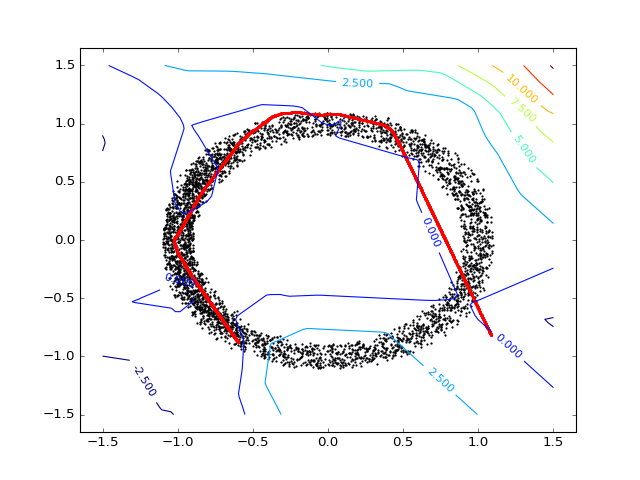

loss 0.244139 0.309994 1.40951


/Users/hoqqanen/envs/tf3/lib/python3.5/site-packages/matplotlib/contour.py:370: RuntimeWarning: invalid value encountered in true_divide
  dist = np.add.reduce(([(abs(s)[i] / L[i]) for i in range(xsize)]), -1)


loss 0.530124 0.572152 0.909832
loss 0.459435 0.558333 0.871996
loss 0.594502 0.625578 0.931003


In [8]:
%matplotlib notebook

fig,ax = plt.subplots(1,1)
counter = 0
np.random.shuffle(data)
z_data = np.random.uniform(-1, 1, [4000, input_size]).astype(np.float32)

# Define these out here since they don't change.
grid = np.mgrid[-1.5:1.5:100j, -1.5:1.5:100j]
pts = np.dstack(grid).reshape(-1, 2)
X, Y = grid

for epoch in range(20):
    batch_idxs = len(data)//batch_size
    for idx in range(0, batch_idxs):
        if idx%5==0:
            ax.clear()
            ax.scatter([g[0] for g in data], [g[1] for g in data], s=1) # True distribution
            gen = g_output.eval({z: z_data})
            ax.scatter([g[0] for g in gen], [g[1] for g in gen], color=[1,0,0,1], s=2) # Generator's embedding

            z_contour = d_output_real.eval({real_data_input: pts})
            CS = ax.contour(X, Y, np.reshape(z_contour, [100, 100]), 8) # Discriminator's predictions
            ax.clabel(CS, inline=1, fontsize=10)

            fig.canvas.draw()
            fig.savefig('videos/test%03d.png' % counter, format='png')
            counter += 1
        
        real_data_batch = np.array(data[idx*batch_size:(idx+1)*batch_size]).astype(np.float32)
        batch_z = np.random.uniform(-1, 1, [batch_size, input_size]).astype(np.float32)
        sess.run([d_optim], feed_dict={ z: batch_z, real_data_input: real_data_batch })
        sess.run([g_optim], feed_dict={ z: batch_z })
    if epoch%5 == 0:
        print("loss", 
              d_loss_real.eval({real_data_input: real_data_batch}), 
              d_loss_fake.eval({z: batch_z}),
              g_loss.eval({z: batch_z}))

# Projecting points onto the manifold

We can project points in the generator's output space onto the manifolds learned by both the generator and discriminator. For the generator, this takes the form of setting the point as a desired target, initializing an input Z to the generator, and performing SGD on Z until the output of the generator is minimized. Similarly for the discriminator, we may take the target point P and perform SGD to optimize the output of the discriminator.

The latter, however, will in some cases, such as this notebook, diverge (the point runs to infinity). This is entirely possible in the general case, as the true data is bounded (and hence the generator will be as well), allowing the disciminator to be arbitrarily confident about points outside of this bound being in the true set or not.

We could however combine these approaches to confine the search to things that G can generate while simultenously maximizing the discriminator's prediction and minimizing the distance to P. The tradeoff between these two terms is a free parameter.

In [11]:
target_point = tf.constant([-1.5, 1.5]) # Assumes output_size is 2
z_sample = tf.Variable([[0.5]], name="z_sample")
g_sample_output = create_g_output(z_sample)
sess.run(z_sample.initializer)

p_loss = tf.reduce_sum(tf.square(tf.sub(target_point, g_sample_output))) # output's distance to target_point
projection_optim = tf.train.GradientDescentOptimizer(0.01).minimize(p_loss, var_list=[z_sample])

<IPython.core.display.Javascript object>


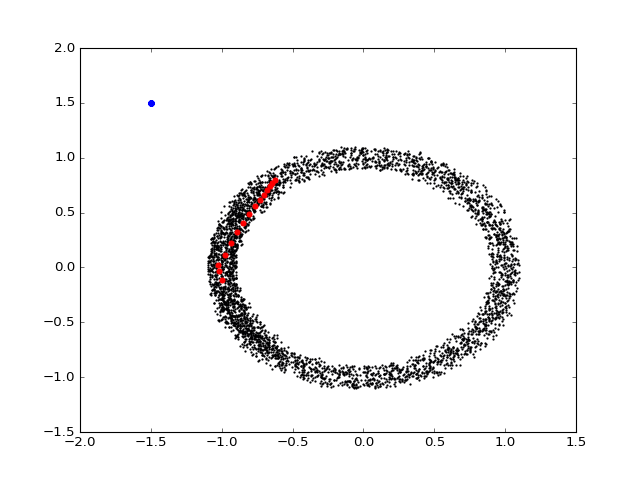

Projected point:  [[-0.61414224  0.81675833]]


In [12]:
%matplotlib notebook
fig,ax = plt.subplots(1,1)
ax.scatter([g[0] for g in data], [g[1] for g in data], s=1) # True distribution

previous_loss = p_loss.eval()
loss_delta = 1
while loss_delta > .01:
    gen = g_sample_output.eval()
    ax.scatter([g[0] for g in gen], [g[1] for g in gen], color=[1,0,0,1], s=20) # Generator's embedding
    fig.canvas.draw()
    tp = target_point.eval()
    ax.scatter([tp[0]], [tp[1]], color=[0,0,1,1], s=20) # Generator's embedding
    fig.canvas.draw()

    sess.run([projection_optim])
    loss_delta = abs(p_loss.eval() - previous_loss)
    previous_loss = p_loss.eval()

print("Projected point: ", g_sample_output.eval())